# Предсказание рейтинга


В ходе этой работы мне захотелось предсказать на основе полученного ранее датасета оценку фильма на основе жанра, возрастного рейтинга и т.д.

In [ ]:
import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

### Служебные вещи

Это добро можно запускать и в коллабе, все соответствующие ячейки я закомментировала

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# ds = pd.read_csv('movies_50000.csv')

### Подгружаем данные

...и приводим колонки в виду, который было бы адекватно кодировать

In [ ]:
pd.options.display.max_columns = None

In [ ]:
ds = pd.read_csv('movies_50000.csv')

In [ ]:
ds.head(10)

,Unnamed: 0,title,genre,year,certificate,runtime,user-votes,imdb-scores,metacritic-scores,descriptions,stars
0,0,The Fall of the House of Usher,"Drama,Horror,Mystery",2023.0,TV-MA,493,67677,8.0,No data,To secure their fortune (and future) two ruthl...,"\n Stars:\nCarla Gugino, \nBruc..."
1,1,Killers of the Flower Moon,"Crime,Drama,History",2023.0,R,206,83339,8.0,89,When oil is discovered in 1920s Oklahoma under...,Director:\nMartin Scorsese\n| \n Stars:...
2,2,Bodies,"Crime,Drama,History",2023.0,TV-MA,455,24785,7.4,No data,Four detectives in four different time periods...,"\n Stars:\nAmaka Okafor, \nKyle..."
3,3,Pain Hustlers,"Crime,Drama",2023.0,R,122,21650,6.5,44,Liza dreams of a better life for herself and h...,Director:\nDavid Yates\n| \n Stars:\nEm...
4,4,Gen V,"Action,Adventure,Comedy",2023.0,TV-MA,50,47232,7.9,No data,"From the world of ""The Boys"" comes ""Gen V,"" wh...","\n Stars:\nJaz Sinclair, \nChan..."
5,5,A Haunting in Venice,"Crime,Drama,Horror",2023.0,PG-13,103,55485,6.6,63,"In post-World War II Venice, Poirot, now retir...",Director:\nKenneth Branagh\n| \n Stars:...
6,6,All the Light We Cannot See,"Drama,History,War",2023.0,TV-MA,228,14208,7.7,No data,"The story of Marie-Laure, a blind French teena...","\n Stars:\nAria Mia Loberti, \n..."
7,7,The Killer,"Action,Adventure,Crime",2023.0,R,118,47041,7.0,72,"After a fateful near-miss, an assassin battles...",Director:\nDavid Fincher\n| \n Stars:\n...
8,8,Invincible,"Animation,Action,Adventure",2021.0,TV-MA,50,172289,8.7,No data,An adult animated series based on the Skybound...,"\n Stars:\nSteven Yeun, \nJ.K. ..."
9,9,The Gilded Age,Drama,2022.0,TV-MA,81,29509,8.0,No data,A wide-eyed young scion of a conservative fami...,"\n Stars:\nBen Ahlers, \nDebra ..."


In [ ]:
ds = ds.drop(columns=['Unnamed: 0', 'descriptions', 'stars'])

In [ ]:
ds.runtime[ds.runtime == 'No data'] = -1
ds['runtime'] = ds['runtime'].replace(',','', regex=True).astype('int')

<ipython-input-7-53aef23a4612>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds.runtime[ds.runtime == 'No data'] = -1


Глубокая мысль runtime bins заключается в том, что мы смотрим, является ли это коротким метром, фильмом на 1,5 часа, фильмом подольше, мини-сериалом или продолжительным сериалом

In [ ]:
ds['runtimeBIN'] = pd.cut(ds['runtime'], bins=[0,60,100,240,1000,10000], labels = [0,1,2,3,4], include_lowest = True)

In [ ]:
ds['year'] = ds['year'].astype('float')
ds['year_finish'] = ds['year'] % 10000
ds['year_start'] = np.where(ds['year'] // 10000 == 0, ds['year_finish'], ds['year'] // 10000)

In [ ]:
ds = pd.concat([ds, pd.DataFrame(ds["genre"].str.split(',').fillna('[]').tolist(), columns=['genre_1', 'genre_2', 'genre_3'])], axis=1)

In [ ]:
ds['century_start'] = ds['year_start'] // 10
ds['century_finish'] = ds['year_finish'] // 10

In [ ]:
(ds['genre_2'].value_counts() + ds['genre_1'].value_counts() + ds['genre_3'].value_counts()).index

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

In [ ]:
for i in range(len((ds['genre_2'].value_counts() + ds['genre_1'].value_counts() + ds['genre_3'].value_counts()).index)):
  ds[(ds['genre_2'].value_counts() + ds['genre_1'].value_counts() + ds['genre_3'].value_counts()).index[i]] = 0

In [ ]:
ds['No_genre'] = 0

In [ ]:
ds['genre_2'] = ds['genre_2'].fillna('No_genre')
ds['genre_3'] = ds['genre_3'].fillna('No_genre')

In [ ]:
for i in range(1,4):
  for j in range(len(ds)):
    ds[ds['genre_'+str(i)][j]][j] = 1


<ipython-input-16-c782aad7b2ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds[ds['genre_'+str(i)][j]][j] = 1


Унифицируем зоопарк разных рейтингов с помощью гугления

In [ ]:
ds['certificate'] = ds['certificate'].replace({'TV-MA':'18+', 'R':'18+', 'TV-14':'14+', 'PG-13':'14+', 'No data':'Not_rated', 'TV-PG':'14+',
                           'Not Rated':'Not_rated', 'PG':'14+', 'TV-G':'14+', 'Unrated':'Not_rated', 'Approved':'0+', 'G':'0+',
                           'Passed':'0+', 'M':'18+', 'TV-Y7':'6+', 'NC-17':'18+', 'GP':'14+', '16+':'18+', 'X':'18+', 'TV-Y':'6+', '13+':'14+',
                           'T':'14+', 'M/PG':'18+', 'MA-17':'18+'})

In [ ]:
labelencoder = LabelEncoder()
ds['certificate'] = labelencoder.fit_transform(ds['certificate'])
ds['certificate'] = ds['certificate'].astype('int')

In [ ]:
ds = ds[ds['imdb-scores'] != 'No data']
ds = ds.drop_duplicates()

In [ ]:
X = ds.drop(columns=['title', 'genre', 'year', 'runtime', 'imdb-scores', 'metacritic-scores', 'year_finish', 'year_start', 'genre_1', 'genre_2',
                     'genre_3', 'No_genre'])
y = ds['imdb-scores'].astype('float')

In [ ]:
X['user-votes'] = pd.to_numeric(X['user-votes'], errors='coerce').fillna(0)

### Обучение LGBM из коробки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [ ]:
categ_feat_idx = sorted(list(range(5, len(X.columns))) + [0, 2])

In [ ]:
lgbm_model = LGBMRegressor(categorical_feature = categ_feat_idx, metric='mae')

In [ ]:
lgbm_model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
lgbm_test_preds = lgbm_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 32242, number of used features: 27
[LightGBM] [Info] Start training from score 7.723200


In [ ]:
mean_absolute_error(y_test, lgbm_test_preds)

0.12997468820078467

LGBM MAE 0.12997468820078467

In [ ]:
lgbm_test_preds[:5]

array([8.08400846, 9.48515462, 8.41849546, 9.07196803, 6.663346  ])

Смотрим, похоже ли итоговое распределение на исходное. Вдруг получилось так, что мы предсказываем с погрешностью 0.2 балла все фильмы из диапазона скора 7.9-8.1?

<ipython-input-36-5e3208cb7380>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lgbm_test_preds, hist=True, kde=False,


Text(0, 0.5, 'Number of scores')

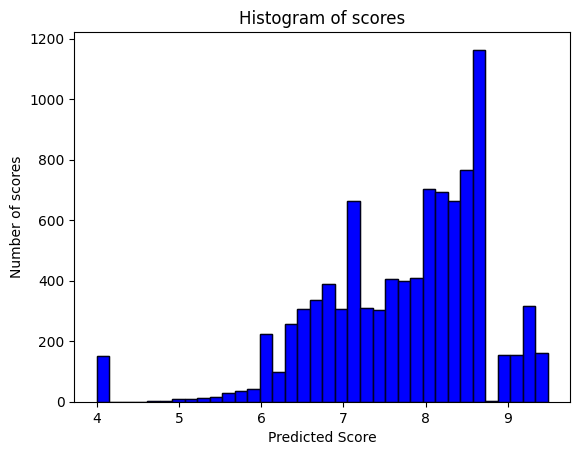

In [ ]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(lgbm_test_preds, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram
sns.distplot(lgbm_test_preds, hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of scores')
plt.xlabel('Predicted Score')
plt.ylabel('Number of scores')

### Кастомный LGBM c Cython 

In [ ]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [ ]:
%%cython -a

import itertools
import numpy as np
cimport numpy as np
from itertools import *
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error as mse

cdef class RegressionTreeFastMse:

    cdef public int max_depth
    cdef public int feature_idx
    cdef public int min_size
    cdef public int averages

    cdef public np.float64_t feature_threshold
    cdef public np.float64_t value

    cdef RegressionTreeFastMse left
    cdef RegressionTreeFastMse right

    def __init__(self, max_depth=3, min_size=4, averages=1):

        self.max_depth = max_depth
        self.min_size = min_size
        self.value = 0
        self.feature_idx = -1
        self.feature_threshold = 0
        self.left = None
        self.right = None

    def fit(self, np.ndarray[np.float64_t, ndim=2] X, np.ndarray[np.float64_t, ndim=1] y):

        cdef np.float64_t mean1 = 0.0
        cdef np.float64_t mean2 = 0.0
        cdef long N = X.shape[0]
        cdef long N1 = X.shape[0]
        cdef long N2 = 0
        cdef np.float64_t delta1 = 0.0
        cdef np.float64_t delta2 = 0.0
        cdef np.float64_t sm1 = 0.0
        cdef np.float64_t sm2 = 0.0
        cdef list index_tuples
        cdef list stuff
        cdef long idx = 0

        cdef np.float64_t prev_error1 = 0.0
        cdef np.float64_t prev_error2 = 0.0
        cdef long thres = 0
        cdef np.float64_t error = 0.0

        cdef np.ndarray[long, ndim=1] idxs

        cdef np.float64_t x = 0.0


        self.value = y.mean()

        base_error = ((y - self.value) ** 2).sum()
        error = base_error
        flag = 0


        if self.max_depth <= 1:
            return

        dim_shape = X.shape[1]

        left_value, right_value = 0, 0

        for feat in range(dim_shape):

            prev_error1, prev_error2 = base_error, 0
            idxs = np.argsort(X[:, feat])


            mean1, mean2 = y.mean(), 0
            sm1, sm2 = y.sum(), 0

            N = X.shape[0]
            N1, N2 = N, 0
            thres = 1

            while thres < N - 1:
                N1 -= 1
                N2 += 1

                idx = idxs[thres]
                x = X[idx, feat]


                delta1 = (sm1 - y[idx]) * 1.0 / N1 - mean1
                delta2 = (sm2 + y[idx]) * 1.0 / N2 - mean2


                sm1 -= y[idx]
                sm2 += y[idx]


                prev_error1 += (delta1**2) * N1
                prev_error1 -= (y[idx] - mean1)**2
                prev_error1 -= 2 * delta1 * (sm1 - mean1 * N1)
                mean1 = sm1/N1

                prev_error2 += (delta2**2) * N2
                prev_error2 += (y[idx] - mean2)**2
                prev_error2 -= 2 * delta2 * (sm2 - mean2 * N2)
                mean2 = sm2/N2


                if thres < N - 1 and np.abs(x - X[idxs[thres + 1], feat]) < 1e-5:
                    thres += 1
                    continue

                if (prev_error1 + prev_error2 < error):
                    if (min(N1,N2) > self.min_size):


                        self.feature_idx, self.feature_threshold = feat, x

                        left_value, right_value = mean1, mean2


                        flag = 1
                        error = prev_error1 + prev_error2

                thres += 1


        if self.feature_idx == -1:
            return


        self.left = RegressionTreeFastMse(self.max_depth - 1)
        self.left.value = left_value
        self.right = RegressionTreeFastMse(self.max_depth - 1)
        self.right.value = right_value


        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)


        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])

    def __predict(self, np.ndarray[np.float64_t, ndim=1] x):

        if self.feature_idx == -1:
            return self.value

        if x[self.feature_idx] > self.feature_threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)

    def predict(self, np.ndarray[np.float64_t, ndim=2] X):

        y = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])

        return y



class GradientBoosting():

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 random_state=17, n_samples = 15, min_size = 5, base_tree='Bagging'):

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.initialization = lambda y: np.mean(y) * np.ones([y.shape[0]])
        self.min_size = min_size
        self.loss_by_iter = []
        self.trees_ = []
        self.loss_by_iter_test = []
        self.n_samples = n_samples
        self.base_tree = base_tree


    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)

        prediction = b.copy()

        for t in tqdm_notebook(range(self.n_estimators)):

            if t == 0:
                resid = y
            else:

                resid = (y - prediction)


            if self.base_tree == 'Bagging':
                tree = Bagging(max_depth=self.max_depth,
                                       min_size = self.min_size)
            if self.base_tree == 'Tree':
                tree = RegressionTreeFastMse(max_depth=self.max_depth,
                                          min_size = self.min_size)


            tree.fit(X, resid)

            b = tree.predict(X).reshape([X.shape[0]])
            self.trees_.append(tree)
            prediction += self.learning_rate * b

            if t > 0:
                self.loss_by_iter.append(mse(y,prediction))

        return self

    def predict(self, X):


        pred = np.ones([X.shape[0]]) * np.mean(self.y)

        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X).reshape([X.shape[0]])

        return pred

In [ ]:
X_train_numpy = X_train.to_numpy()
X_test_numpy = X_test.to_numpy()
y_train_numpy = y_train.to_numpy()

In [ ]:
GDB = GradientBoosting(n_estimators=50, base_tree='Tree')
GDB.fit(X_train_numpy, y_train_numpy)
x_pred_our_GDB = GDB.predict(X_test_numpy)
plt.grid()
plt.title('Loss by iterations')
plt.plot(GDB.loss_by_iter)

In [ ]:
mean_absolute_error(y_test, x_pred_our_GDB)

OUR GDB MAE 0.3640009655576941